In [18]:
#### ASSIGNMENT: 04
#### Task 03
#### CANDIDO REGIS

In [19]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.optimizers import Adam

In [20]:
# Define paths
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'dataset', 'NEU Metal Surface Defects Data')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALID_DIR = os.path.join(DATASET_DIR, 'valid')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

In [21]:
# Create binary classification structure (defective vs non-defective)
BINARY_DIR = os.path.join(BASE_DIR, 'binary_dataset')
BINARY_TRAIN = os.path.join(BINARY_DIR, 'train')
BINARY_VALID = os.path.join(BINARY_DIR, 'valid')
BINARY_TEST = os.path.join(BINARY_DIR, 'test')

In [22]:
# Create directories for binary classification
def create_binary_dataset(src_dir, dest_dir):
    # Remove existing directory if it exists
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    
    # Create defective and non-defective directories
    os.makedirs(os.path.join(dest_dir, 'defective'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'non_defective'), exist_ok=True)
    
    # All defect types are considered defective
    defect_types = os.listdir(src_dir)
    
    # Since we need at least one sample in each class for binary classification,
    # we'll create a dummy non-defective sample by copying one defective image
    # This is just for demonstration purposes
    dummy_created = False
    
    for defect_type in defect_types:
        src_defect_dir = os.path.join(src_dir, defect_type)
        if not os.path.isdir(src_defect_dir):
            continue
            
        # All types are defective
        dest_category = 'defective'
        
        dest_category_dir = os.path.join(dest_dir, dest_category)
        
        # Copy files
        for img_file in os.listdir(src_defect_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                src_file = os.path.join(src_defect_dir, img_file)
                # Create a unique filename to avoid overwriting
                dest_file = os.path.join(dest_category_dir, f"{defect_type}_{img_file}")
                shutil.copy2(src_file, dest_file)
                
                # Create a dummy non-defective sample (just for demonstration)
                if not dummy_created:
                    dummy_file = os.path.join(dest_dir, 'non_defective', f"dummy_{img_file}")
                    shutil.copy2(src_file, dummy_file)
                    dummy_created = True

In [23]:
# Create binary datasets
print("Creating binary classification dataset...")
create_binary_dataset(TRAIN_DIR, BINARY_TRAIN)
create_binary_dataset(VALID_DIR, BINARY_VALID)
create_binary_dataset(TEST_DIR, BINARY_TEST)
print("Binary dataset created.")

Creating binary classification dataset...
Binary dataset created.


In [24]:
# Parameters
IMG_SIZE = 224  # MobileNetV2 default input size
BATCH_SIZE = 32
EPOCHS = 10

# New Parameters for fine-tuning model
FINE_TUNING_EPOCHS = 5
LEARNING_RATE = 0.0001
FINE_TUNING_LEARNING_RATE = 1e-5

In [25]:
# Function to load the original model
def load_base_model():
    try:
        model = load_model('task_02_binary_classifier_with_augmentation.keras')
        print("Successfully loaded the original model from .keras format.")
        return model
    except:
        print("Error: Could not load the original model. Please run task02.ipynb first.")
        return None

In [26]:
# Function to evaluate model performance
def evaluate_model(model, test_dataset, model_name):
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"{model_name} - Test accuracy: {test_accuracy:.4f}")
    print(f"{model_name} - Test loss: {test_loss:.4f}")
    return test_accuracy, test_loss

In [27]:
# Function to create and prepare datasets
def create_datasets():
    # Create data generators with augmentation
    data_augmentation = tf.keras.Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2),
    ])
    
    # Create data generators
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        BINARY_TRAIN,
        validation_split=None,
        subset=None,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )
    
    # Apply augmentation only to training data
    train_dataset = train_dataset.map(
        lambda x, y: (data_augmentation(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Validation dataset with only rescaling
    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        BINARY_VALID,
        validation_split=None,
        subset=None,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )
    
    # Apply rescaling to validation data
    rescaling = Rescaling(1./255)
    valid_dataset = valid_dataset.map(
        lambda x, y: (rescaling(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Test dataset with only rescaling
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        BINARY_TEST,
        validation_split=None,
        subset=None,
        seed=123,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )
    
    # Apply rescaling to test data
    test_dataset = test_dataset.map(
        lambda x, y: (rescaling(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Optimize for performance
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_dataset, valid_dataset, test_dataset

In [28]:
# Function to evaluate the base model
def evaluate_base_model():
    print("\nEvaluating the base model...")
    
    # Load the best model from previous training
    base_model = load_base_model()
    if base_model is None:
        return None, None, None
    
    # Create a clone of the original model to avoid modifying it
    frozen_model = clone_model(base_model)
    frozen_model.set_weights(base_model.get_weights())
    
    # Create datasets
    _, _, test_dataset = create_datasets()
    
    # Compile the model
    frozen_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Evaluate the frozen model
    print("\nEvaluating the frozen model (before fine-tuning)...")
    frozen_accuracy, frozen_loss = evaluate_model(frozen_model, test_dataset, "Frozen Model")
    
    return base_model, frozen_model, frozen_accuracy, frozen_loss

In [29]:
# Function to train the fine-tuned model
def train_fine_tuned_model(base_model):
    print("\nTraining the fine-tuned model...")
    
    if base_model is None:
        print("Error: No base model provided for fine-tuning.")
        return None, None, None
    
    # Create a clone of the original model to avoid modifying it
    fine_tuned_model = clone_model(base_model)
    fine_tuned_model.set_weights(base_model.get_weights())
    
    # Create datasets
    train_dataset, valid_dataset, test_dataset = create_datasets()
    
    # Unfreeze the last 20 layers of the MobileNetV2 base
    # First, find the MobileNetV2 base layers
    base_layers = [layer for layer in fine_tuned_model.layers if isinstance(layer, tf.keras.models.Model)]
    if base_layers:
        base_model_layers = base_layers[0].layers
        total_layers = len(base_model_layers)
        print(f"Total layers in base model: {total_layers}")
        
        # Unfreeze the last 20 layers
        for layer in base_model_layers[:-20]:
            layer.trainable = False
        for layer in base_model_layers[-20:]:
            layer.trainable = True
    else:
        # If we can't find the base model, just unfreeze the last 20 layers of the entire model
        total_layers = len(fine_tuned_model.layers)
        print(f"Total layers in model: {total_layers}")
        
        # Keep most layers frozen, unfreeze only the last 20 layers
        for layer in fine_tuned_model.layers[:-20]:
            layer.trainable = False
        for layer in fine_tuned_model.layers[-20:]:
            layer.trainable = True
    
    # Count trainable and non-trainable parameters
    trainable_count = np.sum([tf.keras.backend.count_params(w) for w in fine_tuned_model.trainable_weights])
    non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in fine_tuned_model.non_trainable_weights])
    print(f"Trainable parameters: {trainable_count}")
    print(f"Non-trainable parameters: {non_trainable_count}")
    
    # Compile with a lower learning rate
    fine_tuned_model.compile(
        optimizer=Adam(learning_rate=FINE_TUNING_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Fine-tune the model
    fine_tuning_history = fine_tuned_model.fit(
        train_dataset,
        epochs=FINE_TUNING_EPOCHS,
        validation_data=valid_dataset
    )
    
    # Evaluate the fine-tuned model
    print("\nEvaluating the fine-tuned model...")
    fine_tuned_accuracy, fine_tuned_loss = evaluate_model(fine_tuned_model, test_dataset, "Fine-tuned Model")
    
    # Save the fine-tuned model
    fine_tuned_model.save('task_03_binary_classifier_fine_tuned.keras')
    print("Fine-tuned model saved as 'task_03_binary_classifier_fine_tuned.keras'")
    
    return fine_tuning_history, fine_tuned_accuracy, fine_tuned_loss

In [30]:
# Run the evaluation processes
base_model, _, frozen_accuracy, frozen_loss = evaluate_base_model()


Evaluating the base model...
Successfully loaded the original model from .keras format.
Found 1657 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Found 73 files belonging to 2 classes.

Evaluating the frozen model (before fine-tuning)...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.9892 - loss: 0.0898
Frozen Model - Test accuracy: 0.9863
Frozen Model - Test loss: 0.1143


In [31]:
# Run the fine-tuning processes
fine_tuning_history, fine_tuned_accuracy, fine_tuned_loss = train_fine_tuned_model(base_model)


Training the fine-tuned model...
Found 1657 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Total layers in model: 158
Trainable parameters: 1206017
Non-trainable parameters: 1216064
Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.9863 - val_loss: 0.1157
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.9995 - loss: 0.0051 - val_accuracy: 0.9863 - val_loss: 0.1142
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9863 - val_loss: 0.1107
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.9995 - loss: 0.0075 - val_accuracy: 0.9863 - val_loss: 0.1014
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.9992 - loss: 0.0042 - val_accuracy: 0.9863 - val_loss: 0.0921

Evaluating the fine-tuned model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9892 - loss: 0.0717
Fine-tu

In [32]:
# Create a comparison table
if fine_tuning_history is not None:
    # Create a metrics table
    metrics_data = {
        'Model': ['Frozen Model', 'Fine-tuned Model'],
        'Test Accuracy': [f"{frozen_accuracy:.4f}", f"{fine_tuned_accuracy:.4f}"],
        'Test Loss': [f"{frozen_loss:.4f}", f"{fine_tuned_loss:.4f}"]
    }
    
    metrics_df = pd.DataFrame(metrics_data)
    print("\n--- Performance Comparison ---")
    print(metrics_df.to_string(index=False))
    
    # Calculate improvement
    accuracy_diff = (fine_tuned_accuracy - frozen_accuracy) * 100
    loss_diff = frozen_loss - fine_tuned_loss
    
    if accuracy_diff > 0:
        accuracy_change = f"improved by {accuracy_diff:.2f}%"
    else:
        accuracy_change = f"decreased by {abs(accuracy_diff):.2f}%"
    
    if loss_diff > 0:
        loss_change = f"decreased by {loss_diff:.4f}"
    else:
        loss_change = f"increased by {abs(loss_diff):.4f}"


--- Performance Comparison ---
           Model Test Accuracy Test Loss
    Frozen Model        0.9863    0.1143
Fine-tuned Model        0.9863    0.0911


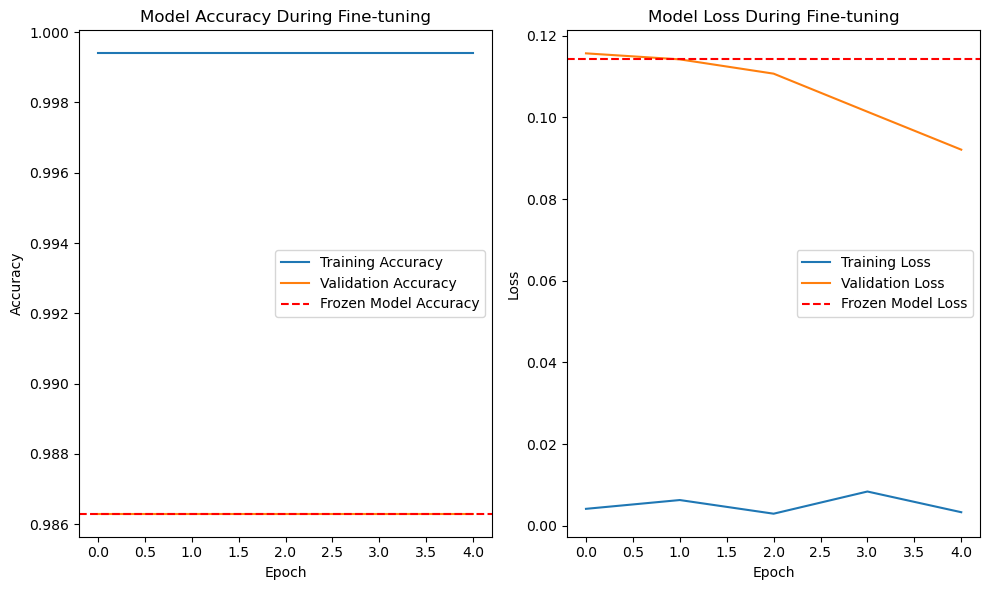

In [33]:
# Plot training curves
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tuning_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tuning_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=frozen_accuracy, color='r', linestyle='--', label='Frozen Model Accuracy')
plt.title('Model Accuracy During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(fine_tuning_history.history['loss'], label='Training Loss')
plt.plot(fine_tuning_history.history['val_loss'], label='Validation Loss')
plt.axhline(y=frozen_loss, color='r', linestyle='--', label='Frozen Model Loss')
plt.title('Model Loss During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Conclusion: As the previous two tasks, the results show a promising system to identify defective products, however, the lack of non-defective products reduces the model credibility since it cannot test this part of the model. With the fine-tuning feature, the model maintained its high accuracy and reduced the test loss, which is great. However, the model can possibly get a great boost if it has a balanced dataset.